# Credit Card Fraud Detection Project
*By: Herman Lin and Mahika Jain*
---
blah

In [140]:
# Importing the libraries to be used:
import sklearn
from sklearn import preprocessing, svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.neural_network import MLPClassifier

import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
%matplotlib inline

# Constants used throughout the code
cVals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

In [141]:
# Read .csv file and put data into a pandas dataframe
df = pd.read_csv('archive.zip')
print(df.shape)

(284807, 31)


In [142]:
# Drop empty columns
df1 = df.dropna('columns')
print(df1.shape)

(284807, 31)


In [143]:
# Convert dataframe into a numpy array
df2 = np.array(df1)
print(df2.shape)

(284807, 31)


In [144]:
# Printing the names of all the features
# - Note: Most feature names have been anonymized to preserve confidentiality
features = np.array(df.columns[:30])
print('Feature Names:', features)

Feature Names: ['Time' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10' 'V11' 'V12'
 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22' 'V23' 'V24'
 'V25' 'V26' 'V27' 'V28' 'Amount']


### Note:

The credit card dataset we are using for this project is naturally unbalanced. There are significantly more examples that are classified as non-fradulent than there are fradulent. One way to help counteract this is to undersample the majority class and oversample the minority class. Thus, we will be scaling our training set to contain a ratio of 5:1 non-fradulent to fradulent as well as using a fraction of the original dataset as our training and validation sets.

In [145]:
# Separate the data into class_0 and class_1 examples
zero = []
one = []
num_examples = df2.shape[0]

for i in range(num_examples):
    if df2[i][30] == 0:
        zero.append(df2[i])
    else: 
        one.append(df2[i])

class_0 = np.array(zero)
class_1 = np.array(one)

In [146]:
# Verify shapes of class_0 and class_1
print('Number of Class 0:', class_0.shape[0])
print('Number of Class 1:', class_1.shape[0])

Number of Class 0: 284315
Number of Class 1: 492


In [147]:
# Randomly choose 2460 examples from the entire class_0 set
class_0_reduced = class_0[np.random.choice(284315, 2460, replace=False),:] 

In [148]:
# Combine samples together and randomize the samples
reduced_data = np.concatenate((class_0_reduced, class_1))
np.random.shuffle(reduced_data)
print(reduced_data.shape)

(2952, 31)


In [149]:
# Separate columns into features and target
X = np.array(reduced_data[:,0:30]) # all rows, first 30 columns
y = np.array(reduced_data[:,30]) # all rows, last column

# sklearn Model Implementation

We have created a function for easy model testing of the data. By specifying certain parameters, we are able to run either a Logisitic Regression Model (with different regularization methods) or an SVM Model (with different kernels).

In [150]:
def sklearn_model(X_tr, y_tr, X_ts, y_ts, m_type, c, iters, penalty='none', kernel=None, hidden_layer_sizes=None, activation=None):
    acc_tr_model = []
    acc_ts_model = []
    c_model = []
    model = None

    # create model 
    if m_type == 0:
        print('Training Logistic Regression Model...')
        model = LogisticRegression(penalty=penalty, C=c, solver='saga', max_iter=iters)
    elif m_type == 1:
        print('Training SVM Model...')
        model = svm.SVC(probability=True, kernel=kernel, C=c)
    elif m_type == 2:
        print('Training Neural Network...')
        model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, alpha=0.0001, max_iter=iters)
    
    # fit the model
    model.fit(X_tr, y_tr)

    # calculate and add accuracy values to respective lists
    acc_tr = model.score(X_tr, y_tr)
    acc_tr_model.append(acc_tr)
    #print("Accuracy on training data = %f" % acc_tr)
    acc_ts = model.score(X_ts, y_ts)
    acc_ts_model.append(acc_ts)
    #print("Accuracy on test data = %f" % acc_ts)

    # appending value of c for graphing purposes if needed
    c_model.append(c)

    # creating a confusion matrix for analysis
    confuse_matrix_tr = confusion_matrix(y_tr, model.predict(X_tr))
    class_report_tr = classification_report(y_tr, model.predict(X_tr))
    confuse_matrix_ts = confusion_matrix(y_ts, model.predict(X_ts))
    class_report_ts = classification_report(y_ts, model.predict(X_ts))
    
    print("Model Complete!")

    return (acc_tr_model, acc_ts_model, c_model), (confuse_matrix_tr, confuse_matrix_ts), (class_report_tr, class_report_ts), model

# Logisitic Regression


### Step 1: Data Preprocessing

In [151]:
# Scale the data by preprocessing
# - The idea behind StandardScaler is that it will transform your data such that 
#   its distribution will have a mean value 0 and standard deviation of 1.
# - Mean Subtraction: for every feature subtract the mean
#   Normalization: make all features roughly the same size
#       X’ = (x-mean)/std

X_scale = preprocessing.StandardScaler().fit_transform(X)

In [152]:
# Split the reduced_data into the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.3, random_state=133)

In [153]:
print('\n======================Before StandardScalar==========================')
print(X)
print('\n=======================After StandardScalar==========================')
print(X_scale)


======================Before StandardScalar==========================
[[ 1.60446000e+05  2.89918409e-02 -4.14626368e+00 ... -3.52240527e-01
   9.91846186e-02  1.18420000e+03]
 [ 1.65556000e+05 -8.50427128e-01  1.75460573e+00 ...  3.07633199e-01
   1.61428613e-01  7.78000000e+00]
 [ 3.24100000e+04  4.53889218e-01 -5.93772038e-01 ...  2.40654475e-02
   1.40232279e-01  1.00000000e+01]
 ...
 [ 6.77810000e+04 -8.27146794e-01 -2.79884209e-01 ...  3.54484109e-01
   1.10795214e-01  1.00000000e+00]
 [ 1.41967000e+05 -9.06648302e-01 -1.68566446e+00 ...  6.16481661e-01
  -1.51259337e-01  6.86500000e+02]
 [ 8.72020000e+04 -4.19820174e-01 -1.15597801e+00 ... -2.13631449e-02
   1.29096386e-01  4.51270000e+02]]

=======================After StandardScalar==========================
[[ 1.45895111e+00  2.24833596e-01 -1.78659411e+00 ... -5.79976405e-01
   2.06833581e-01  4.01071849e+00]
 [ 1.56668394e+00 -9.35986435e-03  4.36425244e-01 ...  4.09331204e-01
   3.73548805e-01 -3.44134161e-01]
 [-1.2403993

### Step 2: Create and run the logistic regression model

In [154]:
# Perform Logisitic Regression with no Regularization
# Pass a large value of C (for example, C = 100000000) to make lambda (C = 1/lambda) nearly 0.
accs_c_logreg, conf_m_logreg, class_r_logreg, logreg_model = sklearn_model(X_train, y_train, X_test, y_test, 0, 100000000, 10000)


# For logreg with regularization: 
# Pass the value of C = c. Note that C is the inverse of lambda. So, small value of C i.e. b/w 0 and 1 
# means stronger regularization and large value means less regularization.

# Perform Logistic Regression with L1 Regularization
logreg_l1 = []
for c in cVals:
    logreg_l1.append((sklearn_model(X_train, y_train, X_test, y_test, 0, c, 10000, 'l1')))

# Perform Logistic Regression with L2 Regularization
logreg_l2 = []
for c in cVals:
    logreg_l2.append((sklearn_model(X_train, y_train, X_test, y_test, 0, c, 10000, 'l2')))


Training Logistic Regression Model...
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
Model Complete!
Training Logistic Regression Model...
Model Complete!
Training Logistic Regression Model...
Model Complete!
Training Logistic Regression Model...
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

### Step 3: Write results from the logistic regression models into a file

In [155]:
# write results into logreg_results.txt
with open("logreg_results.txt", 'w') as file:
    file.write("\n\n============================== Logistic Regression without Regularization ==============================\n")
    file.write("Accuracy on training data = {}\n".format(accs_c[0]))
    file.write("Accuracy on testing data = {}\n".format(accs_c[1]))
    file.write("=== Confusion Matrices ===\n")
    file.write("Training: \n{}\n".format(confusion_matrices[0]))
    file.write("Testing: \n{}\n".format(confusion_matrices[1]))
    file.write("=== Class Reports ===\n")
    file.write("Training: \n{}\n".format(class_reports[0]))
    file.write("Testing: \n{}\n".format(class_reports[1]))

    file.write("\n\n============================== Logistic Regression with L1 Regularization ==============================\n")
    i = 0
    for c in cVals:    
        file.write("===== C VALUE: {} =====\n".format(c))
        file.write("Accuracy on training data = {}\n".format(logreg_l1[i][0][0]))
        file.write("Accuracy on testing data = {}\n".format(logreg_l1[i][0][1]))
        file.write("=== Confusion Matrices ===\n")
        file.write("Training: \n{}\n".format(logreg_l1[i][1][0]))
        file.write("Testing: \n{}\n".format(logreg_l1[i][1][1]))
        file.write("=== Class Reports ===\n")
        file.write("Training: \n{}\n".format(logreg_l1[i][2][0]))
        file.write("Testing: \n{}\n".format(logreg_l1[i][2][1]))
        i += 1
    
    file.write("\n\n============================== Logistic Regression with L2 Regularization ==============================\n")
    i = 0
    for c in cVals:    
        file.write("===== C VALUE: {} =====\n".format(c))
        file.write("Accuracy on training data = {}\n".format(logreg_l2[i][0][0]))
        file.write("Accuracy on testing data = {}\n".format(logreg_l2[i][0][1]))
        file.write("=== Confusion Matrices ===\n")
        file.write("Training: \n{}\n".format(logreg_l2[i][1][0]))
        file.write("Testing: \n{}\n".format(logreg_l2[i][1][1]))
        file.write("=== Class Reports ===\n")
        file.write("Training: \n{}\n".format(logreg_l2[i][2][0]))
        file.write("Testing: \n{}\n".format(logreg_l2[i][2][1]))
        i += 1

### Step 4: Plot results from the logistic regression models

We will be plotting the results using Precision-Recall Curves since we are dealing with a large class imbalance

### Plot PR Curve for Logistic Regression without Regularization

Text(0.5, 1.0, 'Logistic Regression no Regularization')

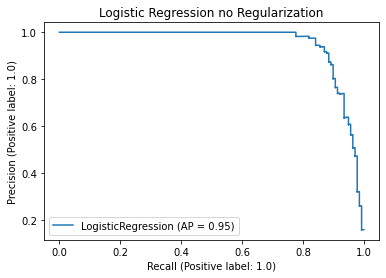

In [156]:
plot_precision_recall_curve(logreg_model, X_test, y_test)
plt.title("Logistic Regression no Regularization")

### Plot PR Curve for Logistic Regression with L1 Regularization

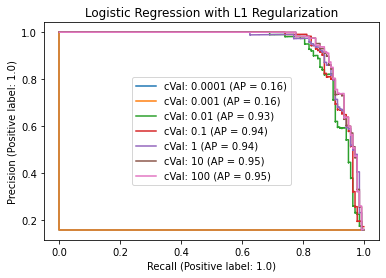

In [157]:
for model in logreg_l1:
    plot_precision_recall_curve(model[3], X_test, y_test, ax=plt.gca(), name='cVal: {}'.format(model[0][2][0]))
plt.title("Logistic Regression with L1 Regularization")
plt.legend(loc='center')

### Plot PR Curve for Logistic Regression with L2 Regularization

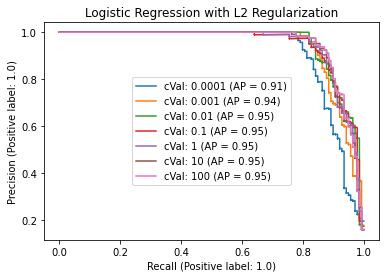

In [158]:
for model in logreg_l2:
    plot_precision_recall_curve(model[3], X_test, y_test, ax=plt.gca(), name='cVal: {}'.format(model[0][2][0]))
plt.title("Logistic Regression with L2 Regularization")
plt.legend(loc='center')

# Support Vector Machines

### Step 1: Run SVM with each kernel

In [159]:
# SVM with Linear Kernel
svm_linear_results = []
for c in cVals:
    svm_linear_results.append((sklearn_model(X_train, y_train, X_test, y_test, 1, c, 0, kernel='linear')))

Training SVM Model...
Model Complete!
Training SVM Model...
Model Complete!
Training SVM Model...
Model Complete!
Training SVM Model...
Model Complete!
Training SVM Model...
Model Complete!
Training SVM Model...
Model Complete!
Training SVM Model...
Model Complete!


In [160]:
# SVM with Radial Basis Function Kernel
svm_rbf_results = []
for c in cVals:
    svm_rbf_results.append((sklearn_model(X_train, y_train, X_test, y_test, 1, c, 0, kernel='rbf')))

Training SVM Model...
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\

In [161]:
# SVM with Polynomial Kernel
cValsGeom = np.geomspace(0.000001, 0.001, 5)
svm_poly_results = []
for c in cValsGeom:
    svm_poly_results.append((sklearn_model(X_train, y_train, X_test, y_test, 1, c, 0, kernel='poly')))

Training SVM Model...
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Hermano\anaconda3\

In [162]:
svm_linear_results[0][0]

([0.8906098741529526], [0.8893905191873589], [0.0001])

### Step 2: Record data obtained from the SVMs

In [163]:
# write results into svm_results.txt
with open("svm_results.txt", 'w') as file:
    file.write("\n\n============================== SVM with Linear Kernel ==============================\n")
    i = 0
    for c in cVals:    
        file.write("===== C VALUE: {} =====\n".format(c))
        file.write("Accuracy on training data = {}\n".format(svm_linear_results[i][0][0]))
        file.write("Accuracy on testing data = {}\n".format(svm_linear_results[i][0][1]))
        file.write("=== Confusion Matrices ===\n")
        file.write("Training: \n{}\n".format(svm_linear_results[i][1][0]))
        file.write("Testing: \n{}\n".format(svm_linear_results[i][1][1]))
        file.write("=== Class Reports ===\n")
        file.write("Training: \n{}\n".format(svm_linear_results[i][2][0]))
        file.write("Testing: \n{}\n".format(svm_linear_results[i][2][1]))
        i += 1

    file.write("\n\n============================== SVM with RBF Kernel ==============================\n")
    i = 0
    for c in cVals:    
        file.write("===== C VALUE: {} =====\n".format(c))
        file.write("Accuracy on training data = {}\n".format(svm_rbf_results[i][0][0]))
        file.write("Accuracy on testing data = {}\n".format(svm_rbf_results[i][0][1]))
        file.write("=== Confusion Matrices ===\n")
        file.write("Training: \n{}\n".format(svm_rbf_results[i][1][0]))
        file.write("Testing: \n{}\n".format(svm_rbf_results[i][1][1]))
        file.write("=== Class Reports ===\n")
        file.write("Training: \n{}\n".format(svm_rbf_results[i][2][0]))
        file.write("Testing: \n{}\n".format(svm_rbf_results[i][2][1]))
        i += 1
    
    file.write("\n\n============================== SVM with Polynomial Kernel ==============================\n")
    i = 0
    for c in cValsGeom:    
        file.write("===== C VALUE: {} =====\n".format(c))
        file.write("Accuracy on training data = {}\n".format(svm_poly_results[i][0][0]))
        file.write("Accuracy on testing data = {}\n".format(svm_poly_results[i][0][1]))
        file.write("=== Confusion Matrices ===\n")
        file.write("Training: \n{}\n".format(svm_poly_results[i][1][0]))
        file.write("Testing: \n{}\n".format(svm_poly_results[i][1][1]))
        file.write("=== Class Reports ===\n")
        file.write("Training: \n{}\n".format(svm_poly_results[i][2][0]))
        file.write("Testing: \n{}\n".format(svm_poly_results[i][2][1]))
        i += 1

### Step 3: Plot the results obtained from the SVM models

Text(0.5, 1.0, 'SVM with Linear Kernel')

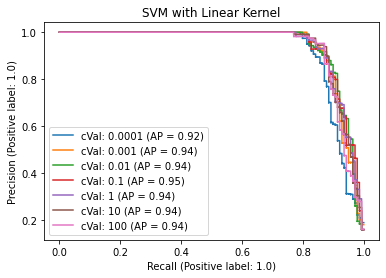

In [164]:
# linear kernel
for model in svm_linear_results:
    plot_precision_recall_curve(model[3], X_test, y_test, ax=plt.gca(), name='cVal: {}'.format(model[0][2][0]))
plt.title("SVM with Linear Kernel")

Text(0.5, 1.0, 'SVM with RBF Kernel')

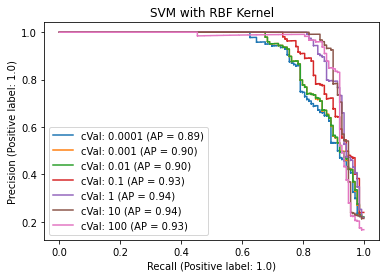

In [165]:
# radial basis function kernel
for model in svm_rbf_results:
    plot_precision_recall_curve(model[3], X_test, y_test, ax=plt.gca(), name='cVal: {}'.format(model[0][2][0]))
plt.title("SVM with RBF Kernel")

Text(0.5, 1.0, 'SVM with Polynomial Kernel')

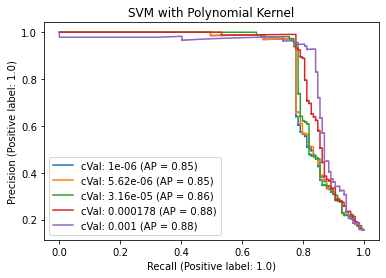

In [166]:
# polynomial kernel
for model in svm_poly_results:
    plot_precision_recall_curve(model[3], X_test, y_test, ax=plt.gca(), name='cVal: {:2.3}'.format(model[0][2][0]))
plt.title("SVM with Polynomial Kernel")

# Neural Networks

### Step 1: Run Neural Networks

In [167]:
relu_results = []
tanh_results = []
logi_results = []

activations = ['relu', 'tanh', 'logsitic']
iters = 10000 # sklearn's MLPClassifier halts further iterations after the training converges
layers = [(22), (22, 22), (22, 22, 22), (30)]
# default L2 penalty = 0.0001

In [168]:
for l in layers:
    print("layer: ", l)
    relu_results.append(sklearn_model(X_train, y_train, X_test, y_test, 2, 0, iters, hidden_layer_sizes=l, activation='relu'))
    tanh_results.append(sklearn_model(X_train, y_train, X_test, y_test, 2, 0, iters, hidden_layer_sizes=l, activation='tanh'))
    logi_results.append(sklearn_model(X_train, y_train, X_test, y_test, 2, 0, iters, hidden_layer_sizes=l, activation='logistic'))

layer:  22
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
layer:  (22, 22)
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
layer:  (22, 22, 22)
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
layer:  30
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!
Training Neural Network...
Model Complete!


In [169]:
relu_results

[(([0.9956437560503388], [0.9774266365688488], [0]),
  (array([[1712,    1],
          [   8,  345]], dtype=int64),
   array([[742,   5],
          [ 15, 124]], dtype=int64)),
  ('              precision    recall  f1-score   support\n\n         0.0       1.00      1.00      1.00      1713\n         1.0       1.00      0.98      0.99       353\n\n    accuracy                           1.00      2066\n   macro avg       1.00      0.99      0.99      2066\nweighted avg       1.00      1.00      1.00      2066\n',
   '              precision    recall  f1-score   support\n\n         0.0       0.98      0.99      0.99       747\n         1.0       0.96      0.89      0.93       139\n\n    accuracy                           0.98       886\n   macro avg       0.97      0.94      0.96       886\nweighted avg       0.98      0.98      0.98       886\n'),
  MLPClassifier(hidden_layer_sizes=22, max_iter=10000)),
 (([0.9990319457889641], [0.9695259593679458], [0]),
  (array([[1713,    0],
       

### Step 2: Record data obtained from the neural networks run

In [170]:
# write results into nn_results.txt
with open("nn_results.txt", 'w') as file:
    file.write("\n\n============================== Neural Network with ReLU Activation ==============================\n")
    i = 0
    for model in relu_results:
        file.write("=============== Iterations: {0}, Hidden Layers: {1} ===============\n".format(model[3].n_iter_, layers[i % 4]))
        file.write("Accuracy on training data = {}\n".format(model[0][0]))
        file.write("Accuracy on testing data = {}\n".format(model[0][1]))
        file.write("=== Confusion Matrices ===\n")
        file.write("Training: \n{}\n".format(model[1][0]))
        file.write("Testing: \n{}\n".format(model[1][1]))
        file.write("=== Class Reports ===\n")
        file.write("Training: \n{}\n".format(model[2][0]))
        file.write("Testing: \n{}\n".format(model[2][1]))
        i += 1

    file.write("\n\n============================== Neural Network with tanh Activation ==============================\n")
    i = 0
    for model in tanh_results:
        file.write("=============== Iterations: {0}, Hidden Layers: {1} ===============\n".format(model[3].n_iter_, layers[i % 4]))
        file.write("Accuracy on training data = {}\n".format(model[0][0]))
        file.write("Accuracy on testing data = {}\n".format(model[0][1]))
        file.write("=== Confusion Matrices ===\n")
        file.write("Training: \n{}\n".format(model[1][0]))
        file.write("Testing: \n{}\n".format(model[1][1]))
        file.write("=== Class Reports ===\n")
        file.write("Training: \n{}\n".format(model[2][0]))
        file.write("Testing: \n{}\n".format(model[2][1])) 

    file.write("\n\n============================== Neural Network with Logistic (Sigmoid) Activation ==============================\n")
    i = 0
    for model in logi_results:
        file.write("=============== Iterations: {0}, Hidden Layers: {1} ===============\n".format(model[3].n_iter_, layers[i % 4]))
        file.write("Accuracy on training data = {}\n".format(model[0][0]))
        file.write("Accuracy on testing data = {}\n".format(model[0][1]))
        file.write("=== Confusion Matrices ===\n")
        file.write("Training: \n{}\n".format(model[1][0]))
        file.write("Testing: \n{}\n".format(model[1][1]))
        file.write("=== Class Reports ===\n")
        file.write("Training: \n{}\n".format(model[2][0]))
        file.write("Testing: \n{}\n".format(model[2][1])) 

### Step 3: Plot results obtained from the neural networks

Text(0.5, 1.0, 'Neural Network: ReLU Activation')

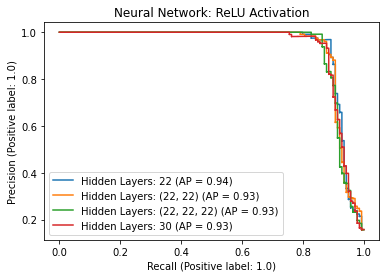

In [171]:
# NN with ReLU
for i in range(len(relu_results)):
    plot_precision_recall_curve(relu_results[i][3], X_test, y_test, ax=plt.gca(), name='Hidden Layers: {}'.format(layers[i%4]))
plt.title("Neural Network: ReLU Activation")

Text(0.5, 1.0, 'Neural Network: tanh Activation')

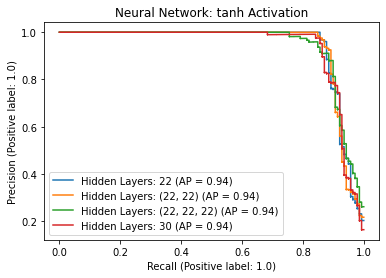

In [172]:
# NN with tanh
for i in range(len(tanh_results)):
    plot_precision_recall_curve(tanh_results[i][3], X_test, y_test, ax=plt.gca(), name='Hidden Layers: {}'.format(layers[i%4]))
plt.title("Neural Network: tanh Activation")

Text(0.5, 1.0, 'Neural Network: Logistic/Sigmoid Activation')

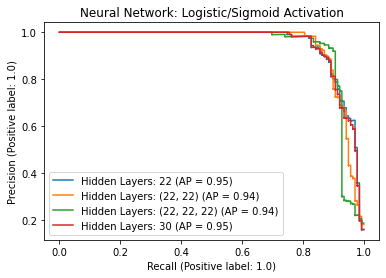

In [173]:
# NN with logistic (sigmoid)
for i in range(len(logi_results)):
    plot_precision_recall_curve(logi_results[i][3], X_test, y_test, ax=plt.gca(), name='Hidden Layers: {}'.format(layers[i%4]))
plt.title("Neural Network: Logistic/Sigmoid Activation")